# **Deep Q-Networks (DQN)**


### **Part 6**: Reinforcement Learning (from Zero to One)

*African Institute for Mathematical Sciences (AIMS), South Africa
11 November, 2024*

**Arnu Pretorius** - Staff Research Scientist, InstaDeep

*Credits*: Adapted from Deep Learning Indaba 2022. Apache License 2.0.


## Setup

In [ ]:
# @title Install required packages (run me) { display-mode: "form" }
# @markdown This may take a minute or two to complete.
%%capture
!sudo apt install swig
!pip install jaxlib
!pip install jax
!pip install git+https://github.com/deepmind/dm-haiku
!pip install gym
!pip install gym[box2d]
!pip install optax
!pip install matplotlib
!pip install chex

In [ ]:
# @title Import required packages (run me) { display-mode: "form" }
%%capture
import copy
from shutil import rmtree # deleting directories
import random
import collections # useful data structures
import numpy as np
import gym # reinforcement learning environments
from gym.wrappers import RecordVideo
import jax
import jax.numpy as jnp # jax numpy
import haiku as hk # jax neural network library
import optax # jax optimizer library
import matplotlib.pyplot as plt # graph plotting library
from IPython.display import HTML
from base64 import b64encode
import chex

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

### **Environment (warm-up)**

We will begin by using the simple **CartPole** environment. In CartPole, the task is for the agent to learn to balance a pole for as long as possible by moving a cart *left* or *right*.

<img src="https://miro.medium.com/max/600/1*v8KcdjfVGf39yvTpXDTCGQ.gif" width="30%" />

- **State space**: The state of the environment is represented by four numbers; *angular position of the pole, angular velocity of the pole, position of the cart, velocity of the cart*.
- **Action space**: There are only two actions; *left* and *right*. As such, the actions can be represented by integers $0$ and $1$.  
- **Dynamics**: State transitions are deterministic and the agent receives a reward of `1` for every timestep the pole is still upright. If the pole falls over, the game is over and the agent receives no more reward. The game is also over after `500` timesteps, so the maximum reward the agent can collect is `500`.

In CartPole, the environment is considered solved when the agent can reliably achieve an episode return of 500.

In [ ]:
# Create the environment
env_name = "CartPole-v1"  # "LunarLander-v2" (for later...)
env = gym.make(env_name)

# Reset the environment
s_0 = env.reset()
print("Initial State::", s_0)

# Get environment obs space
obs_shape = env.observation_space.shape
print("Environment Obs Space Shape:", obs_shape)

# Get action space - e.g. discrete or continuous
print(f"Environment action space: {env.action_space}")

# Get num actions
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

Initial State:: [ 0.02881543  0.00703179 -0.01305268  0.01739682]
Environment Obs Space Shape: (4,)
Environment action space: Discrete(2)
Number of actions: 2


## **Q-Learning**


In Q-learning the agent learns a function that approximates the **value** of state-action pairs. By *value* we mean the return you expect to receive if you start in a particular state $S_t$, take a particular action $A_t$, and then act according to a particular policy $\pi$ forever after. The state-action value function of policy $\pi$ is given by

$Q_\pi(s,a)=\mathrm{E}_{\pi}\left[G_t \mid S_t=s,\ A_t=a\right]$.

We say that the value function $Q_\pi(s,a)$ is the **optimal** value function if the policy $\pi$ is an optimal policy. We denote the optimal value function as follows:

$Q_\ast(s,a)=\max \limits_\pi \  \mathrm{E}_{\pi}\left[G_t \mid S_t=s,\ A_t=a\right]$

There is an important relationship between the optimal action $a_\ast$ in a state $s$ and the optimal state-action value function $Q_\ast$. Namely, the optimal action $a_\ast$ in state $s$ is equal to the action that maximises the optimal state-action value function. This relationship naturally induces an optimal policy:

$\pi_\ast(s)=\arg \max \limits_a\ Q_\ast(s, a)$

### **Greedy action selection**

---
> **For you!**
>
> Implement a greedy action selector. This should be a function that, given a vector of Q-values, returns the action with the largest Q-value.
---

**Useful methods:**
*   `jnp.argmax` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.argmax.html)) [note from above we had `import jax.numpy as jnp`]

In [ ]:
# Implement a function takes q-values as input and returns the greedy_action
def select_greedy_action(q_values):

  # YOUR CODE
  action = jnp.argmax(q_values)
  # END YOUR CODE

  return action

In [ ]:
# @title Check your implementation (run me) {display-mode: "form"}

try:
  q_values = jnp.array([1,1,3,4])
  action = select_greedy_action(q_values)

  if action != 3:
    print("Oops! It seems your implementation is incorrect.")
  else:
    print("Looks good!")
except Exception as e:
  print("Oops! It seems you didn't implement anything?")


Looks good!


### **Q-Network**
In Q-learning, we parametrise the Q-function using a neural network $Q_\phi$. We obtain a policy from the Q-network by always choosing the action with the *greatest* value:

$\hat{\pi}_\phi(s)=\arg \max \limits_a\ Q_{\phi}(s, a)$

We use a neural network to approximate this Q-function. The network will take an observation as input and then output a Q-value for each of the available actions. So in the case of CartPole, the output of the network will have size $2$.

In [ ]:
def build_network(num_actions: int, layers=[20, 20]) -> hk.Transformed:
  """Factory for a simple MLP network for approximating Q-values."""

  def q_network(obs):
    network = hk.Sequential(
        [hk.Flatten(),
         hk.nets.MLP(layers + [num_actions])])
    return network(obs)

  return hk.without_apply_rng(hk.transform(q_network))

Let's initialise our Q-network and get the initial parameters.

In [ ]:
# Initialise Q-network
Q_NETWORK = build_network(num_actions=num_actions, layers=[20, 20]) # two actions

dummy_obs = jnp.zeros((1,*obs_shape), jnp.float32) # a dummy observation like the one in CartPole

random_key = jax.random.PRNGKey(42) # random key
Q_NETWORK_PARAMS = Q_NETWORK.init(random_key, dummy_obs) # Get initial params

print("Q-Learning params:", Q_NETWORK_PARAMS.keys())

Q-Learning params: dict_keys(['mlp/~/linear_0', 'mlp/~/linear_1', 'mlp/~/linear_2'])


### **The Bellman Equations**
The value function can be written recursively as:

$Q_{\pi}(s, a) = \mathbb{E}_{s^\prime \sim p(s^\prime |s, a)}\left[r + \gamma\underset{a^{\prime} \sim \pi}{\mathrm{E}}\left[Q_{\pi}\left(s^{\prime}, a^{\prime}\right)\right]\right]$,

Intuitively, this equation says that the value of the action $a$ you took in the state $s$ is equal to the reward $r$ you expect to get, plus the value you expect to get in the next state $s'$ you land in given that you will choose your next action $a'$ with the policy $\pi$. The Bellman equation for the optimal value function is:

$Q_{*}(s, a) = \mathbb{E}_{s^\prime \sim p(s^\prime |s, a)}\left[r +\ \gamma \underset{a^{\prime}}{\max}\ Q_{*}(s^{\prime}, a^{\prime})\right]$

Notice that instead of chosing your next action $a'$ with policy $\pi$, we choose the action with the greatest Q-value.

### **The Bellman Backup**
To learn to approximate the optimal Q-value function, we can use the right-hand side of the Bellman equation as an update rule. In other words, suppose we have a Q-network $Q_\phi$, with parameters $\phi$, then we can iteratively update the parameters such that

$Q_\phi(s,a)\leftarrow r + \gamma \underset{a'}{\max}\ Q_\phi(s', a')$.

Intuitively, this says that the approximation of the Q-value of action $a$ in state $s$ should be updated such that it is closer to being equal to the reward received from the environment $r$ plus the value of the best possible action in the next state $s'$. We can perform this optimisation by minimising the difference between the left and right-hand side, with respect to the parameters $\phi$ using gradient descent. We can measure the difference between the two values using the [squared-error](https://en.wikipedia.org/wiki/Mean_squared_error#Loss_function).

---
> **For you!**
>
> Implement the squared-error function.
---

**Useful functions**
* `jnp.square` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.square.html))

In [ ]:
def compute_squared_error(pred, target):
  # YOUR CODE
  squared_error = jnp.square((pred-target))
  # END YOUR CODE

  return squared_error

In [ ]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  result = compute_squared_error(1, 4)

  if result != 9:
    print("Oops! It seems your implementation is incorrect.")
  else:
    print("Looks good!")
except Exception as e:
  print("Oops! It seems you didn't implement anything?")

Looks good!




---
> **For you!**
>
> Implement a function that computes the **Bellman target** (right-hand side of the Bellman equation). If the episode is at the last timestep (i.e. done==1.0), then the Bellman target should be equal to the reward, with no extra value at the end.
---

**Useful functions**
* `jnp.max` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.max.html))

In [ ]:
# Bellman target
def compute_bellman_target(reward, done, next_q_values, gamma=0.99):
  """A function to compute the bellman target.

  Args:
      reward: a scalar reward.
      done: a scalar of value either 1.0 or 0.0, indicating if the transition is a terminal one.
      next_q_values: a vector of q_values for the next state. One for each action.
      gamma: a scalar discount value between 0 and 1.

    -- IMPORTANT NOTE: you should keep the default gamma value to check your implementation

  Returns:
      A scalar equal to the bellman target.

  """

  # YOUR CODE

  bellman_target = jax.lax.cond(
    done == 0.0,  # condition
    lambda _: reward + gamma * jnp.max(next_q_values),  # if done == 0.0
    lambda _: jnp.array(reward, dtype=jnp.float32),  # else (convert reward to float32)
    operand=None  # no shared input required
   )
  return bellman_target

In [ ]:
result1 = compute_bellman_target(1, 0.0, np.array([3,2], "float32"))
result1

Array(3.97, dtype=float32)

In [ ]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  # not done
  result1 = compute_bellman_target(1, 0.0, np.array([3,2], "float32"))

  # done
  result2 = compute_bellman_target(1, 1.0, np.array([3,2], "float32"))

  if np.abs(result1 - 3.97) > 0.0001 or result2 != 1:
    print("Oops! It seems your implementation is incorrect.")
  else:
    print("Looks good!")
except Exception as e:
  print("Oops! It seems you didn't implement anything?")

Looks good!


We can now combine these two functions to compute the loss for Q-learning. The Q-learning loss is equal to the squared difference between the predicted Q-value of an action and its corresponding Bellman target.

---
> **For you!**
>
> Implement the Q-learning loss.
---



In [ ]:
def q_learning_loss(q_values, action, reward, done, next_q_values):
    """Implementation of the Q-learning loss.T

    Args:
        q_values: a vector of Q-values, one for each action.
        action: an integer, giving the action that was chosen. q_values[action] is the value of the chose action.
        done: is a scalar that indicates if this is a terminal transition.
        next_q_values: a vector of Q-values in the next state.
    Returns:
        The squared difference between the q_value of the chosen action and the bellman target.
    """
    # YOUR CODE
    chosen_action_q_value = q_values[action] # q_value of action, use array indexing
    bellman_target        = compute_bellman_target(reward, done, next_q_values, gamma=0.99)
    squared_error         = compute_squared_error(chosen_action_q_value, bellman_target)
    # END YOUR CODE

    return squared_error

In [ ]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  result = q_learning_loss(np.array([3,2], "float32"), 1, 2, 0.0, np.array([3,2], "float32"))
  print(result)

  if np.abs(result - 8.820902) > 0.0001:
    print("Oops! It seems your implementation is incorrect.")
  else:
    print("Looks good!")
except Exception as e:
  print("Oops! It seems you didn't implement anything?")

8.820902
Looks good!


### **Target Q-network**
Notice that when we compute the bellman target we are using our Q-network $Q_\phi$ to compute the value for the next state $S_{t+1}$. We are basically using our latest approximation of the Q-function to compute the target of our next approximation. Using an approximation to compute the target for your next approximation, is called **bootstrapping**.

Unfortunately, if we naively bootstrap like this, it can make training a neural network very unstable. To mitigage this we can instead use a different set of parameters $\bar{\phi}$ to compute the values at state $S_{t+1}$. We will keep the parameters $\bar{\phi}$ fixed and only periodically update them to be equal to the latest online parameters $\phi$ every couple of training steps *(say 100)*. This serves to keep the bellman targets fixed for a couple training steps to help reduce the instability due to bootstrapping.


We will need to keep track of the latest (online) parameters $\phi$, as well as the target networks parameters $\bar{\phi}$. Lets make a `NamedTuple` to store these two values. We will also need to keep track of the number of learner steps we have taken, so that we know when to update the target network. Lets store a `count` of the learn steps in the `learn_state`.

In [ ]:
# Store online and target parameters
QLearnParams = collections.namedtuple("Params", ["online", "target"])

# Q-learn-state
QLearnState = collections.namedtuple("LearnerState", ["count", "optim_state"])

We will be using **Optax** to optimize our neural network. We store the state of the optimizer in the `learn_state` above. Lets now instantiate the optimizer and add the initial Q-network parameters to a `QLearnParams` object.

In [ ]:
# Initialise Q-network optimizer
Q_LEARN_OPTIMIZER = optax.adam(3e-4) # learning rate

Q_LEARN_OPTIM_STATE = Q_LEARN_OPTIMIZER.init(Q_NETWORK_PARAMS) # initial optim state

# Create Learn State
Q_LEARNING_LEARN_STATE = QLearnState(0, Q_LEARN_OPTIM_STATE) # count set to zero initially

# Add initial Q-network weights to QLearnParams object
Q_LEARNING_PARAMS = QLearnParams(online=Q_NETWORK_PARAMS, target=Q_NETWORK_PARAMS) # target equal to online

Now we can implement a simple function that updates the target network parameters to equal the latest online network parameters every 100 training steps.

In [ ]:
def update_target_params(learn_state, online_weights, target_weights, update_frequency=100):
  """A function to update target params every 100 training steps"""

  target = jax.lax.cond(
      jnp.mod(learn_state.count, update_frequency) == 0,
      lambda x, y: x,
      lambda x, y: y,
      online_weights,
      target_weights
  )

  params = QLearnParams(online_weights, target)

  return params

### **Q-learning loss**
We now have everything we need to implement the `q_learn` function which takes some batch of transitions and does a step of Q-learning to update the network paramters. But first we use `jax.vmap` to modify the `q_learning_loss` function so that it accepts batches of transitions. In addition, we will compute the Q-values by passing the observations through the `Q_NETWORK` and the target Q-values using the target parameters of the `Q_NETWORK`.

In [ ]:
def batched_q_learning_loss(online_params, target_params, obs, actions, rewards, next_obs, dones):
    q_values = Q_NETWORK.apply(online_params, obs) # use the online parameters
    next_q_values = Q_NETWORK.apply(target_params, next_obs) # use the target parameters
    squared_error = jax.vmap(q_learning_loss)(q_values, actions, rewards, dones, next_q_values) # vmap q_learning_loss
    mean_squared_error = jnp.mean(squared_error) # mean squared error over batch
    return mean_squared_error

Now we can create the `q_learn` function which computes the gradient of the `batched_q_learning_loss` and then uses an Optax optimizer to update the network weights and then finally (maybe) updates the target parameters.

In [ ]:
def q_learn(rng, params, learner_state, memory):
  # Compute gradients
  grad_loss = jax.grad(batched_q_learning_loss)(params.online, params.target, memory.obs,
                                          memory.action, memory.reward,
                                          memory.next_obs, memory.done,
                                          ) # jax.grad

  # Get updates
  updates, opt_state = Q_LEARN_OPTIMIZER.update(grad_loss, learner_state.optim_state)

  # Apply them
  new_weights = optax.apply_updates(params.online, updates)

  # Maybe update target network
  params = update_target_params(learner_state, new_weights, params.target)

  # Increment learner step counter
  learner_state = QLearnState(learner_state.count + 1, opt_state)

  return params, learner_state

### **A General Purpose RL Training Loop**
We have implemented a general purpose RL training loop for you. The training loop takes several arguments as input but the three most important for you to understand are `agent_select_action_func`, `agent_learn_func` and the `agent_memory`.

* The `agent_select_action_func` should take an observation and set of `agent_params` as input and should return an action.
* The `agent_learn_func` should take the agent's parameters and some "memories" as input and then update and return the agents new parameters.
* The `agent_memory` is a general purpose module we define that can store some relevant information about the agent's experiences in the environment that can be used in the `agent_learn_func`.

Below is the training loop function. You are welcome to go through the code and try to understand it but this is not strictly required.

In [ ]:
#@title Training loop (run me) { display-mode: "form" }

# NamedTuple to store transitions
Transition = collections.namedtuple("Transition", ["obs", "action", "reward", "next_obs", "done"])

# Training Loop
def run_training_loop(env_name, agent_params, agent_select_action_func,
    agent_actor_state=None, agent_learn_func=None, agent_learner_state=None,
    agent_memory=None, num_episodes=1000, evaluator_period=10,
    evaluation_episodes=8, learn_steps_per_episode=1,
    train_every_timestep=False, video_subdir="",):
    """
    This function runs several episodes in an environment and periodically does
    some agent learning and evaluation.

    Args:
        env: a gym environment.
        agent_params: an object to store parameters that the agent uses.
        agent_select_func: a function that does action selection for the agent.
        agent_actor_state (optional): an object that stores the internal state
            of the agents action selection function.
        agent_learn_func (optional): a function that does some learning for the
            agent by updating the agent parameters.
        agent_learn_state (optional): an object that stores the internal state
            of the agent learn function.
        agent_memory (optional): an object for storing an retrieving historical
            experience.
        num_episodes: how many episodes to run.
        evaluator_period: how often to run evaluation.
        evaluation_episodes: how many evaluation episodes to run.
        train_every_timestep: whether to train every timestep rather than at the end
            of the episode.
        video_subdir: subdirectory to store epsiode recordings.

    Returns:
        episode_returns: list of all the episode returns.
        evaluator_episode_returns: list of all the evaluator episode returns.
    """

    # Setup Cartpole environment and recorder
    env = gym.make(env_name, render_mode="rgb_array") # training environment
    eval_env = gym.make(env_name, render_mode="rgb_array") # evaluation environment

    # Video dir
    video_dir = "./video"+"/"+video_subdir

    # Clear video dir
    try:
      rmtree(video_dir)
    except:
      pass

    # Wrap in recorder
    env = RecordVideo(env, video_dir+"/train", episode_trigger=lambda x: (x % evaluator_period) == 0)
    eval_env = RecordVideo(eval_env, video_dir+"/eval", episode_trigger=lambda x: (x % evaluation_episodes) == 0)

    # JAX random number generator
    rng = hk.PRNGSequence(jax.random.PRNGKey(0))
    # env.seed(0) # seed environment for reproducability
    random.seed(0)

    episode_returns = [] # List to store history of episode returns.
    evaluator_episode_returns = [] # List to store history of evaluator returns.
    timesteps = 0
    for episode in range(num_episodes):

        # Reset environment.
        obs = env.reset()
        episode_return = 0
        done = False

        while not done:

            # Agent select action.
            action, agent_actor_state = agent_select_action_func(
                                            next(rng),
                                            agent_params,
                                            agent_actor_state,
                                            np.array(obs)
                                        )

            # Step environment.
            next_obs, reward, done, _ = env.step(int(action))

            # Pack into transition.
            transition = Transition(obs, action, reward, next_obs, done)

            # Add transition to memory.
            if agent_memory: # check if agent has memory
              agent_memory.push(transition)

            # Add reward to episode return.
            episode_return += reward

            # Set obs to next obs before next environment step. CRITICAL!!!
            obs = next_obs

            # Increment timestep counter
            timesteps += 1

            # Maybe learn every timestep
            if train_every_timestep and (timesteps % 4 == 0) and agent_memory and agent_memory.is_ready(): # Make sure memory is ready
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        episode_returns.append(episode_return)

        # At the end of every episode we do a learn step.
        if agent_memory and agent_memory.is_ready(): # Make sure memory is ready

            for _ in range(learn_steps_per_episode):
                # First sample memory and then pass the result to the learn function
                memory = agent_memory.sample()
                agent_params, agent_learner_state = agent_learn_func(
                                                        next(rng),
                                                        agent_params,
                                                        agent_learner_state,
                                                        memory
                                                    )

        if (episode % evaluator_period) == 0: # Do evaluation

            evaluator_episode_return = 0
            for eval_episode in range(evaluation_episodes):
                obs = eval_env.reset()
                done = False
                while not done:
                    action, _ = agent_select_action_func(
                                    next(rng),
                                    agent_params,
                                    agent_actor_state,
                                    np.array(obs),
                                    evaluation=True
                                )

                    obs, reward, done, _ = eval_env.step(int(action))

                    evaluator_episode_return += reward

            evaluator_episode_return /= evaluation_episodes

            evaluator_episode_returns.append(evaluator_episode_return)

            logs = [
                    f"Episode: {episode}",
                    f"Epsilon: {get_epsilon(timesteps)}",
                    f"Episode Return: {episode_return}",
                    f"Average Episode Return: {np.mean(episode_returns[-20:])}",
                    f"Evaluator Episode Return: {evaluator_episode_return}"
            ]

            print(*logs, sep="\t") # Print the logs

    env.close()
    eval_env.close()

    return episode_returns, evaluator_episode_returns

### **Replay Buffer**
For Q-learning, we will need an agent memory that stores entire transitions: `obs`, `action`, `reward`, `next_obs`, `done`. When we retrieve transitions from the memory, they should be chosen randomly from all of the transitions collected so far. In RL, we often call such a module a **replay buffer**. One benefit of using a replay buffer is that experiences can be *re-used* several times for training.

In [ ]:
class TransitionMemory(object):
  """A simple Python replay buffer."""

  def __init__(self, max_size=10_000, batch_size=256):
    self.batch_size = batch_size
    self.buffer = collections.deque(maxlen = max_size)

  def push(self, transition):
    # add transition to the replay buffer
    self.buffer.append(
        (transition.obs, transition.action, transition.reward,
          transition.next_obs, transition.done)
          )

  def is_ready(self):
    return self.batch_size <= len(self.buffer)

  def sample(self):
    # Randomly sample a batch of transitions from the buffer
    random_replay_sample = random.sample(self.buffer, self.batch_size)

    # Batch the transitions together
    obs_batch, action_batch, reward_batch, next_obs_batch, done_batch = zip(*random_replay_sample)

    return Transition(
        np.stack(obs_batch).astype("float32"),
        np.asarray(action_batch).astype("int32"),
        np.asarray(reward_batch).astype("float32"),
        np.stack(next_obs_batch).astype("float32"),
        np.asarray(done_batch).astype("float32")
                      )

# Instantiate the memory
Q_LEARNING_MEMORY = TransitionMemory(max_size=10_000, batch_size=512)

### **Random exploration**
We almost have everything we need for a functioning Q-learning agent. But one problem is that if we always choose the action with the highest Q-value then the agent's policy will be completly *deterministic*. This means the agent will always choose the same strategy. This can pose a problem because at the start of training, the Q-network will be very inaccurate (i.e. a bad aproximation of the true Q-function) and the agent will consistently choose suboptimal actions. Moreover, the agent will never deviate from its suboptimal strategy and discover new, potentially more rewarding  actions. As a result, the Q-network remains inaccurate. Ideally, the agent should try out many different strategies in the beginning so that it can observe the outcomes (rewards) of its actions in different states and so improve its approximation of the Q-function.

One easy way to ensure that the agent tries out many different actions is to let it choose some random actions, instead of the greedy (best) action all the time.

---
> **For you!**
>
> Implement a random action selector! This should be a function that, given the number of possible (discrete) actions, returns a random action.
---



**Useful methods:**

*  `jax.random.randint` ([docs](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.randint.html))

In [ ]:
# key = jax.random.PRNGKey(6) # random key
# num_actions = 8
# jax.random.randint(key = key,shape= (), minval = 0, maxval=num_actions)

In [ ]:
def select_random_action(key, num_actions):

    # YOUR CODE
    action = jax.random.randint(key = key,shape= (), minval = 0, maxval = num_actions)
    # END YOUR CODE

    return action

In [ ]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  random_key1 = random_key = jax.random.PRNGKey(6) # random key
  random_key2 = random_key = jax.random.PRNGKey(1000) # random key
  result1 = select_random_action(random_key1, 2)
  result2 = select_random_action(random_key2, 2)

  if result1 != 1 or result2 != 0:
    print("Oops! It seems your implementation is incorrect.")
  else:
    print("Looks good!", result1,result2)
except:
  print("Oops! It seems your implementation is incorrect.")

Looks good! 1 0


### **$\varepsilon$-greedy action selection**
At the start of training, when the accuracy of the Q-network is low, it is worthwhile for the agent to mostly take random actions so that it can learn about how good or bad certain actions are. However, as the accuracy of the Q-network improves, the agent should start taking fewer random actions and instead start choosing greedy actions with respect to the Q-values. Choosing the best actions given the current Q-network is referred to as **exploitation**. In RL, we typically denote the ratio of random to greedy actions by the value **epsilon** $\varepsilon$. Epsilon is usually a decimal value in the interval $[0,1]$, where for example $\varepsilon=0.4$ means that the agent chooses a random action 40% of the time and the greedy action 60% of the time. It is common in RL to linearly (or exponentially) decrease the value of epsilon over time so that the agent becomes increasingly greedy as the accuracy of its Q-network improves through learning.



---
> **For you!**
>
> Implement an $\varepsilon$ decay schedule. This function should take the number of timesteps as input and return the current epsilon value.
---


In [ ]:
EPSILON_DECAY_TIMESTEPS = 3000 # decay epsilon over 3000 timesteps
EPSILON_MIN = 0.1 # 10% exploration

In [ ]:
def get_epsilon(num_timesteps):
  # YOUR CODE
  epsilon = 1 - num_timesteps/EPSILON_DECAY_TIMESTEPS # decay epsilon

  epsilon = jax.lax.select(
      epsilon < EPSILON_MIN,
      EPSILON_MIN, # if less than min then set to min
      epsilon # else don't change epsilon
  )
  # END YOUR CODE

  return epsilon

In [ ]:
epsilon = 1 -10/EPSILON_DECAY_TIMESTEPS # decay epsilon
epsilon

0.9966666666666667

In [ ]:
#@title Check your implementation (run me) {display-mode: "form"}
def check_get_epsilon(get_epsilon):
  try:
    result1 = get_epsilon(10)
    result2 = get_epsilon(5_010)

    if result1 != 0.99666667 or result2 != 0.1:
      print("Oops! It seems your implementation is incorrect.")
    else:
      print("Looks good!")
  except:
    print("Oops! It seems your implementation is incorrect.")

check_get_epsilon(get_epsilon)


Looks good!


---
> **For you!**
>
> Implement an $\varepsilon$-greedy action selector incorporating the schedule from above.
---

In [ ]:
def select_epsilon_greedy_action(key, q_values, num_timesteps):
    num_actions = len(q_values) # number of available actions

    # YOUR CODE HERE
    epsilon = get_epsilon(num_timesteps) # get epsilon value

    should_explore = jax.random.uniform(key, minval=0.0, maxval=1.0) <= epsilon  # hint: a boolean expression to check if some random number is less than epsilon

    action = jax.lax.select(
        should_explore,
        select_random_action(key, num_actions) , # if should explore
        select_greedy_action(q_values) # if should be greedy
    )
    # END YOUR CODE

    return action

In [ ]:
#@title Check your implementation (run me) {display-mode: "form"}

try:
  rng = hk.PRNGSequence(jax.random.PRNGKey(42))
  dummy_q_values = jnp.array([0,1], jnp.float32)
  num_timesteps = 5010 # very greedy
  actions1 = []
  for i in range(10):
      actions1.append(int(select_epsilon_greedy_action(next(rng), dummy_q_values, num_timesteps)))

  num_timesteps = 0 # completly random
  actions2 = []
  for i in range(10):
      actions2.append(int(select_epsilon_greedy_action(next(rng), dummy_q_values, num_timesteps)))

  if actions1 != [1, 1, 0, 1, 1, 0, 1, 1, 1, 1] or actions2 != [0, 0, 0, 1, 1, 1, 1, 0, 0, 0]:
    print("Oops! It seems your implementation is incorrect.")
  else:
    print("Looks good!")
except:
  print("Oops! It seems your implementation is incorrect.")

Looks good!


### **Q-learning select action**

We now have everything we need to make the `q_learning_select_action` function. We will use the `actor_state` to store a counter which keeps track of the current number of timesteps. We can use the counter to decrement our `epsilon` value.

In [ ]:
# Actor state stores the current number of timesteps
QActorState = collections.namedtuple("ActorState", ["count"])

def q_learning_select_action(key, params, actor_state, obs, evaluation=False):
    obs = jnp.expand_dims(obs, axis=0) # add dummy batch dim
    q_values = Q_NETWORK.apply(params.online, obs)[0] # remove batch dim

    action = select_epsilon_greedy_action(key, q_values, actor_state.count)
    greedy_action = select_greedy_action(q_values)

    action = jax.lax.select(
        evaluation,
        greedy_action,
        action
    )

    next_actor_state = QActorState(actor_state.count + 1) # increment timestep counter

    return action, next_actor_state

Q_LEARNING_ACTOR_STATE = QActorState(0) # counter set to zero

 <font color="red"><big> **Comment**:
 - looks all good ✅

### **Training**
We can now put everything together using the agent-environment loop. We also `jit` the select action function and the learn function for some extra speed!

In [ ]:
# Jit functions
q_learning_select_action_jit = jax.jit(q_learning_select_action)
q_learn_jit = jax.jit(q_learn)

Starting training. This may take a few minutes to complete.
Episode: 0	Epsilon: 0.9953333139419556	Episode Return: 14.0	Average Episode Return: 14.0	Evaluator Episode Return: 9.5
Episode: 10	Epsilon: 0.9259999990463257	Episode Return: 20.0	Average Episode Return: 20.181818181818183	Evaluator Episode Return: 10.125
Episode: 20	Epsilon: 0.8486666679382324	Episode Return: 11.0	Average Episode Return: 22.0	Evaluator Episode Return: 9.25
Episode: 30	Epsilon: 0.7956666946411133	Episode Return: 18.0	Average Episode Return: 19.55	Evaluator Episode Return: 9.875
Episode: 40	Epsilon: 0.7406666874885559	Episode Return: 27.0	Average Episode Return: 16.2	Evaluator Episode Return: 9.375
Episode: 50	Epsilon: 0.6919999718666077	Episode Return: 18.0	Average Episode Return: 15.55	Evaluator Episode Return: 9.375
Episode: 60	Epsilon: 0.652999997138977	Episode Return: 10.0	Average Episode Return: 13.15	Evaluator Episode Return: 9.5
Episode: 70	Epsilon: 0.6053333282470703	Episode Return: 21.0	Average Episod

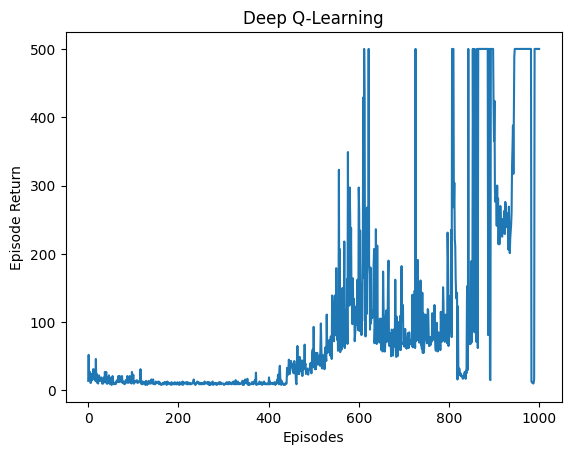

In [ ]:
# Run environment loop
print("Starting training. This may take a few minutes to complete.")
episode_returns, evaluator_returns = run_training_loop(
                                        env_name,
                                        Q_LEARNING_PARAMS,
                                        q_learning_select_action_jit,
                                        Q_LEARNING_ACTOR_STATE,
                                        q_learn_jit,
                                        Q_LEARNING_LEARN_STATE,
                                        Q_LEARNING_MEMORY,
                                        num_episodes=1001,
                                        train_every_timestep=True, # do learning after every timestep
                                        video_subdir="q_learning")

plt.plot(episode_returns)
plt.xlabel("Episodes")
plt.ylabel("Episode Return")
plt.title("Deep Q-Learning")
plt.show()

At this stage, the approximated Q-function hopefully converged to a decent policy for balancing the pole in the CartPole problem.

In [ ]:
#@title Visualise Policy
#@markdown Choose an episode number that is a multiple of 100 and less than or equal to 1000, and **run this cell**.

episode_number = 700 #@param {type:"number"}

assert (episode_number % 100) == 0, "Episode number must be a multiple of 100 since we only record every 100th episode."
assert episode_number < 1001, "Episode number must be less than or equal to 1000"

eval_episode_number = int(episode_number / 100 * 8)
video_path = f"./video/q_learning/eval/rl-video-episode-{792}.mp4"

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

For the original research paper where DQN was first introduced, see here: [Playing Atari with Deep Reinforcement Learning](https://arxiv.org/abs/1312.5602). If you are interested, give the paper a read!

## **Now... to the moon!**

<center>
<img src="https://miro.medium.com/max/1194/1*Dj2fkRjrMA0w9E-PuyETdg.gif" width="60%" />
</center>

Once you have successfully solved CartPole using DQN, you should use what you have learned to help Steve land on the moon!

For this you will use the [LunarLander](https://www.gymlibrary.ml/environments/box2d/lunar_lander/) environment. Simply go to the start of the notebook and replace the environment with LunarLander by replacing `env = gym.make("CartPole-v1")` with env = `gym.make("LunarLander-v2")`. Note, LunarLander is a significantly more challenging environment than CartPole. Therefore, you will likely need to experiment quite a bit to find the best hyperparameters for DQN, and possibly increase the number of training episodes in order to learn a good policy. In LunarLander, the environment is considered solved when the agent can reliably achieve an episode return of 200.


